## __A SEIR approach to the coronavirus infection__

We are interested in simulating numerically the solution to the following SEIR (Sane - Exposed - Infected - Removed) model, to try to fit then guess the numbers on the coronavirus infection. The model is given by (VYNNYCKY and WHITEA, *An introduction to infectious disease modelling*, Oxford University Press 2010):
$$ \left \{\begin{aligned}
 &\frac{dS}{dt} = - \beta \frac{SI}N - \nu S, \\
 & \frac{dE}{dt} = \beta \frac{SI}N - \sigma E, \\
 & \frac{dI}{dt} = \sigma E -(\mu + \gamma) I, \\
 & \frac{dR}{dt} = \gamma I + \nu S,\end{aligned} \right.$$
where $S$ is the number of *sane* individuals, $E$ the *exposed* individuals, $I$ the *infected* and $R$ the *removed/resistant* ones. We assume that we work with a closed population, namely that the *total number* $N$ of individuals, given by 
$$N = S + E + I +R,$$
remains constant over time (at least when no deaths occur). This is of course clear by summing the four differential equations above: If $\mu = 0$, one has
$$\frac{dN}{dt} = \frac{dS}{dt} + \frac{dE}{dt} + \frac{dI}{dt} + \frac{dR}{dt} = 0. $$



As for the parameters, we must distinguish the main three ones: 
* $\beta$ controls the rate a sane-infected contact results in a new exposure;
* $\gamma$ is the rate an infected recovers and moves into the resistant phase. Althugh some reinfection have been noticed in Japan, we won't consider this case here;
* $\sigma$ represents the rate at which an exposed person becomes infective. 

The other two parameters control external behaviors: 
* $\mu$ is the infection mortality rate; 
* $\nu$ is the vaccination rate, which moves people directly from $S$ to $R$.

We shall simulate numerically the solution to this system of ODEs, trying to match the observations from @mixlamalice and others.

**A quick remark.** The model we are dealing with is homogeneous, namely that if $(S,E,I,R)$ is solution, so is $(\lambda S, \lambda E, \lambda I, \lambda R)$ for any $\lambda \in \mathbb{R}$... so looking at total populations or pourcentages will yield the same results, by rescaling with $\lambda$.

In [0]:
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import odeint
import pandas as pd

Let us fix the parameters (simple values, just for doing a sanity check)

In [0]:
BetaGammaSigma = [0.9 , 0.2 , 0.5]
MuNu = [0, 0]

Now we write the SEIR system as a nice autonomous evolution equation
$$ L'(t) = F[L(t)] \in \mathbb R^4$$
with $L = (S, E, I, R)^\top$ and then 
$$ F[L] = \begin{pmatrix} 
- \beta \frac{L_0 L_2}{L_0+L_1+L_2+L_3} - \nu L_0 \\
\beta \frac{L_0 L_2}{L_0+L_1+L_2+L_3} -  \sigma L_1 \\
\sigma L_1 - (\mu + \gamma) L_2 \\
\gamma L_2 + \nu L_0
\end{pmatrix}$$

In [0]:
def F_SEIR(L, t):
    return [- BetaGammaSigma[0]*(L[0]*L[2])/(L[0]+L[1]+L[2]+L[3]) - MuNu[1]*L[0],
            BetaGammaSigma[0]*(L[0]*L[2])/(L[0]+L[1]+L[2]+L[3]) - BetaGammaSigma[2]*L[1],
            BetaGammaSigma[2]*L[1] -  (MuNu[0] + BetaGammaSigma[1])*L[2],
            BetaGammaSigma[1]*L[2] + MuNu[1]*L[0]
           ]

## Let us compute an approximate solution of the system ##

We start by initializing some discrete times

In [0]:
t=linspace(0,30,1000)

And now some initial conditions, again for a sanity check: To

In [0]:
L0 = [0.9,0.1,0,0]
print('Total initial population is {}'.format(sum(L0)))

Total initial population is 1.0


Let's run the model now, using a high order method

Total final population is 0.9999999999999999


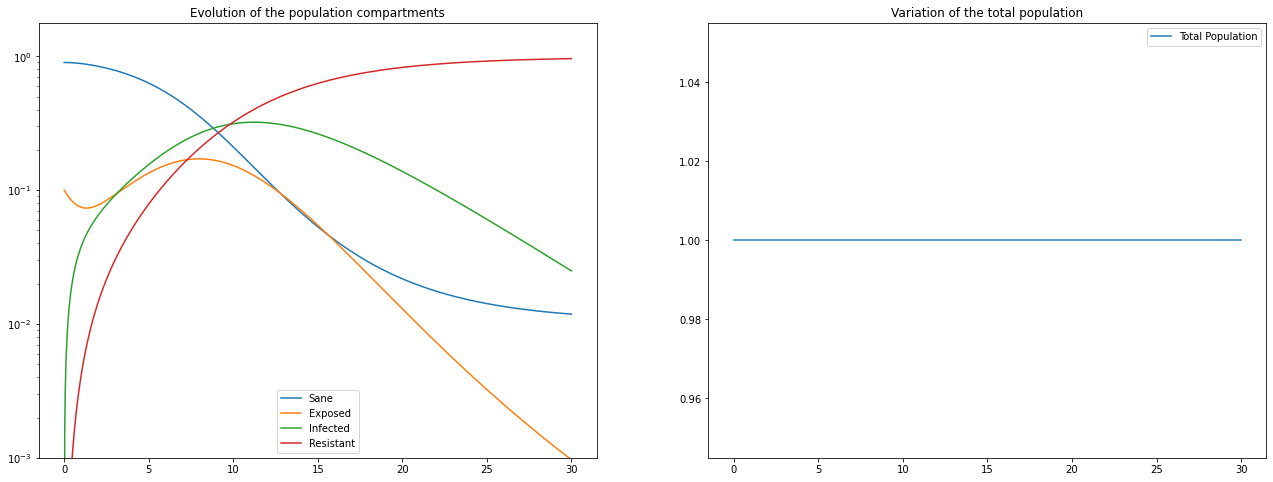

In [0]:
figure(figsize=(22,8))
Lt = odeint(F_SEIR,L0,t)
print('Total final population is {}'.format(sum(Lt[-1,:])))

subplot(121)
title(r'Evolution of the population compartments')
semilogy(t, Lt)
ylim(bottom=1e-3)
legend([r'Sane', r'Exposed', r'Infected', r'Resistant'])

subplot(122)
title(r'Variation of the total population')
plot(t, Lt[:,0]+Lt[:,1]+Lt[:,2]+Lt[:,3], label=r"Total Population")
legend()
show()

##Towards more realistic datum##
According to the medRxiv preprint https://doi.org/10.1101/2020.03.03.20030858 and [REFNEEDED], rates from the Wuhan region are the following:
*  According to official reports [REFNEEDED], 1% to 5% of close contacts are diagnosed as infected, so the probability of passing from the susceptible population (S) to the exposed one (E) is 1% to 5%. We chose to set here the infection probability at the worst rate, 5%. The average daily number of close contacts of a latent person  is $k = 24$ (for adult) according to http://dx.doi.org/10.1016/j.socnet.2007.04.005, so the probability of infection is $\beta = 0.05*24 = 1.2$;
*  Each exposed person (E) is transformed into the infected person (I) at a conversion rate $\sigma$, and the incubation period refers to the time from infection to clinical symptoms of the disease. Covid-19 is currently estimated to have an incubation period of 1 to 12.5 days and a median of 5 to 6 days. According to information on other coronavirus diseases such as MERS and SARS, the incubation period for Covid-19 may be as long as 14 days. WHO recommends 14-day follow-up of contacts in confirmed cases. We shall assume that the incubation period is a maximum of 7 days, and then set $\sigma = 1/7 \simeq 0.143$;
*  The probability of each infected person (I) becoming resistant (R) is (ADDREF) 9.1 days, so $\gamma = 1/9 \simeq 0.11$;
*  The mortality rate is around 3% (ADDREF), so $\mu = 0.03$;
*  No vaccines are currently available, so $\nu = 0$.


In [0]:
BetaGammaSigma = [1.2, 0.11, 0.143]
MuNu = [0.03, 0]

We shall now work on the population of Wuhan, namely $N_0=60,800,000$, and on the hypothesis that initially, only 0.01% of the population were infected:

In [0]:
N0 = 60800000
I0 = 0.0001*N0
L0 = [N0-I0,0,I0,0]
print('Total initial population is {}'.format(sum(L0)))

Total initial population is 60800000.0


Let us now solve the model: We assume that we look on the epidemy on a 6 months period:

In [0]:
t=linspace(0,90,1000)

Total final population is 47804362.79310658


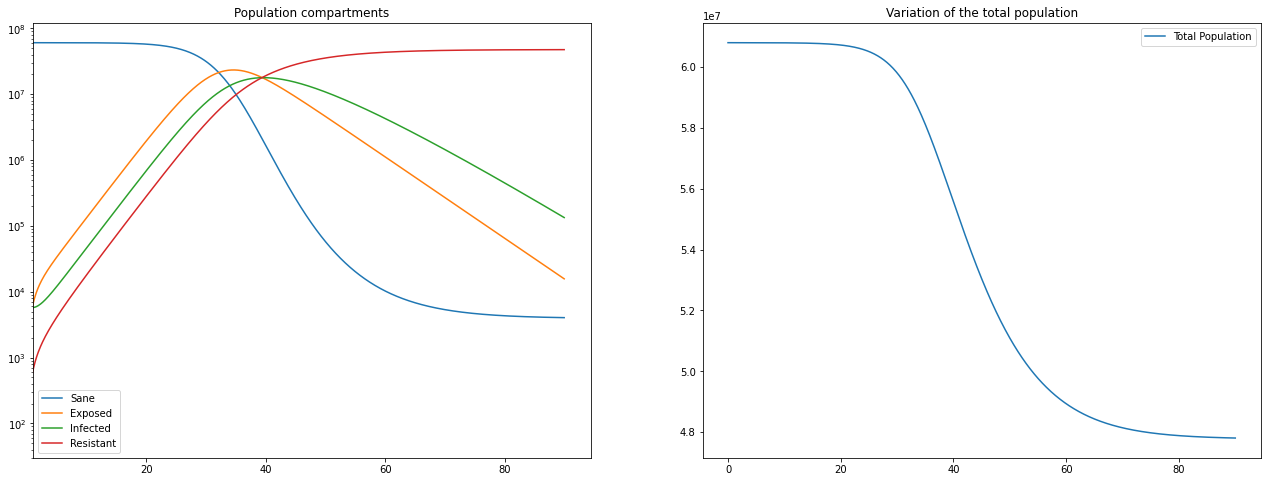

In [0]:
figure(figsize=(22,8))
Lt = odeint(F_SEIR,L0,t)
print('Total final population is {}'.format(sum(Lt[-1,:])))

subplot(121)
semilogy(t, Lt)
title(r'Population compartments')
legend([r'Sane', r'Exposed', r'Infected', r'Resistant'])
xlim(left=1)

subplot(122)
title(r'Variation of the total population')
plot(t, Lt[:,0]+Lt[:,1]+Lt[:,2]+Lt[:,3], label=r"Total Population")
legend()

show()

Freaky, isn't it? The mortality rate is not correct, but the number of infected quickly goes from from a few thousands... to a few million ^^ But... can we compare this with real datum? Let us check: We shall use a very neat trick from this great notebook, that allows us to dynamically get the number of infected in any country 

https://github.com/alonsosilvaallende/COVID-19/blob/master/Coronavirus.ipynb

##Real datum from the WHO##
We shall crunch the numbers from France, Italy and Wuhan, starting when the number of cases is bigger than 100. Source: https://ourworldindata.org/coronavirus-source-data

In [112]:
total_cases = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_cases.csv")
total_death = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv") 

cases100_France = total_cases.query("France > 100")["France"]
days100_France = np.arange(len(cases100_France))
death_France = total_death.query("France > 0")["France"]
death_France_sync = death_France[cases100_France.index[0:]+1]

cases100_Italy = total_cases.query("Italy > 100")["Italy"]
days100_Italy = np.arange(len(cases100_Italy))
death_Italy = total_death.query("Italy > 0")["Italy"]
death_Italy_sync = death_Italy[cases100_Italy.index[0:]+1]

cases100_China = total_cases.query("China > 100")["China"]
days100_China = np.arange(len(cases100_China))
death_China = total_death.query("China > 0")["China"]
death_China_sync = death_China[cases100_China.index[0:]+1]

cases100_Spain = total_cases.query("Spain > 100")["Spain"]
days100_Spain = np.arange(len(cases100_Spain))
death_Spain = total_death.query("Spain > 0")["Spain"]
death_Spain_sync = death_Spain[cases100_Spain.index[0:]+1]

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1146: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Let us plot this data in regular and logarithmic scale

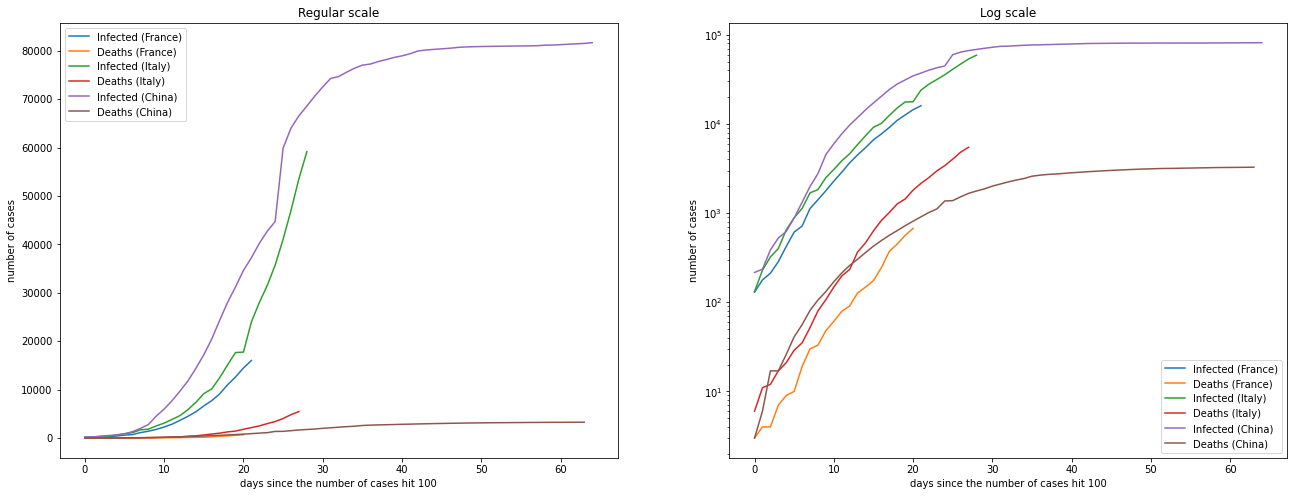

In [113]:
figure(figsize=(22,8))

subplot(121)
title(r'Regular scale')
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
plot(days100_France, cases100_France, label=r'Infected (France)')
plot(days100_France, death_France_sync, label=r'Deaths (France)')
plot(days100_Italy, cases100_Italy,label=r'Infected (Italy)')
plot(days100_Italy, death_Italy_sync, label=r'Deaths (Italy)')
plot(days100_China, cases100_China, label=r'Infected (China)')
plot(days100_China, death_China_sync, label=r'Deaths (China)')
legend()

subplot(122)
title(r'Log scale')
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
semilogy(days100_France, cases100_France, label=r'Infected (France)')
semilogy(days100_France, death_France_sync, label=r'Deaths (France)')
semilogy(days100_Italy, cases100_Italy,label=r'Infected (Italy)')
semilogy(days100_Italy, death_Italy_sync, label=r'Deaths (Italy)')
semilogy(days100_China, cases100_China, label=r'Infected (China)')
semilogy(days100_China, death_China_sync, label=r'Deaths (China)')
legend()
show()

##Can we compare the data of the WHS with our simulation?##

Let us initialize our model with the data from WHS, while we take the parameters from the Wuhan infection. We shall study the French, Italian  and Spanish populations, of roughly resp. 67 millions, 60 millions and 47 millions in 2020, over a 90 days span (up to June).





In [0]:
BetaGammaSigma = [1.2, 0.11, 0.143]
MuNu = [0.03, 0]

Tend = 90
t    = linspace(0,Tend,Tend*10)

N0_f = 67e6
I0_f = cases100_France.iloc[0]
L0_f = [N0_f-I0_f,0,I0_f,0]
Lt_f = odeint(F_SEIR,L0_f,t)

N0_i = 60e6
I0_i = cases100_Italy.iloc[0]
L0_i = [N0_i-I0_i,0,I0_i,0]
Lt_i = odeint(F_SEIR,L0_i,t)

N0_s = 47e6
I0_s = cases100_Spain.iloc[0]
L0_s = [N0_s-I0_s,0,I0_i,0]
Lt_s = odeint(F_SEIR,L0_s,t)

Ndeath_f = N0_f - sum(Lt_f, axis=1) 
Ndeath_i = N0_i - sum(Lt_i, axis=1) 
Ndeath_s = N0_s - sum(Lt_s, axis=1)  

We shall compare the people tested positive to coronavirus from the WHO database with the number of Exposed + Infected given by our model. We notice a sligh overshot from France, but the trajectory is correct, while the agreement with Italy is striking...

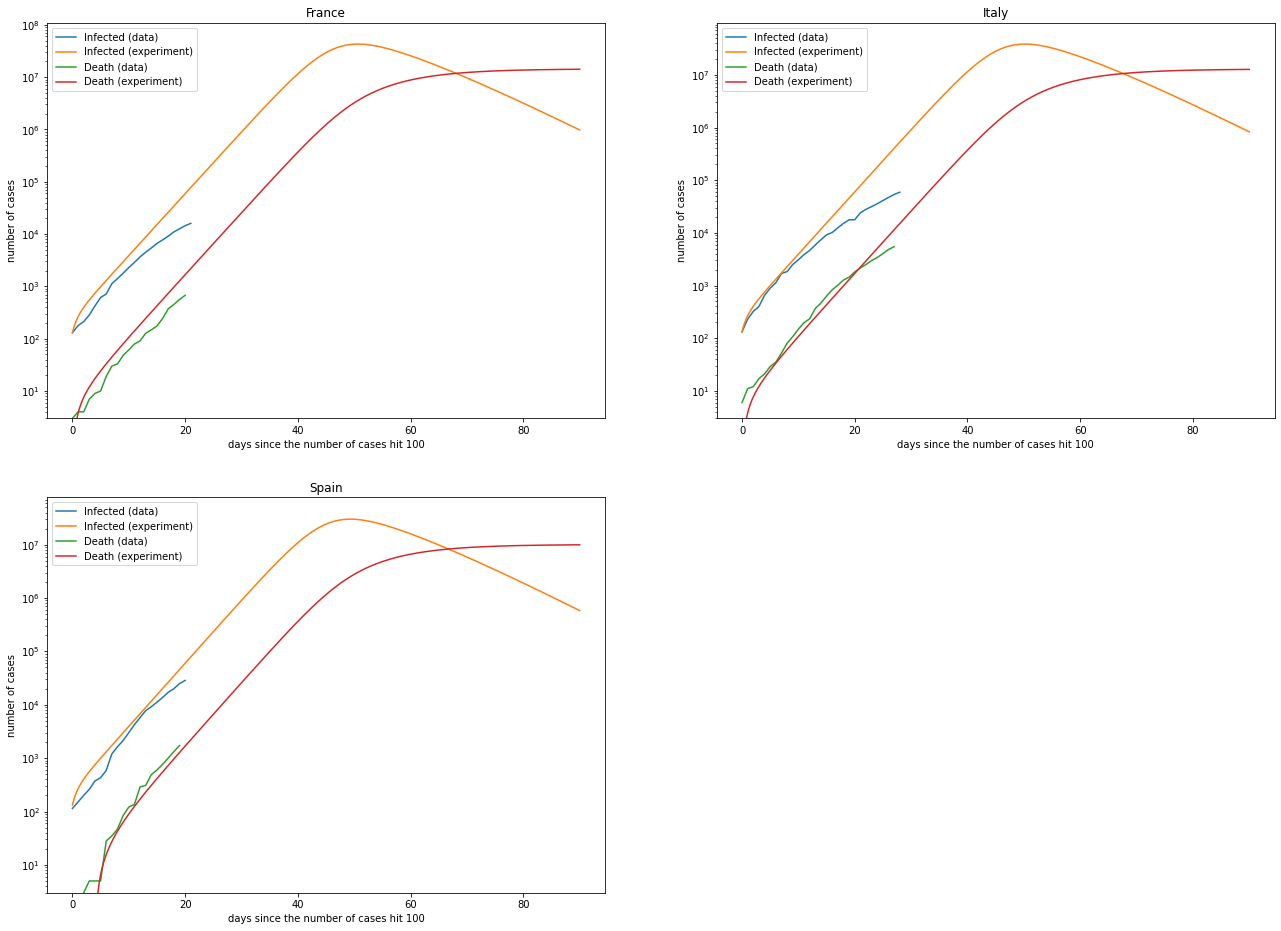

In [116]:
figure(figsize=(22,16))

subplot(221)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('France')
semilogy(days100_France, cases100_France, label=r'Infected (data)')
semilogy(t, Lt_f[:,1]+Lt_f[:,2], label=r'Infected (experiment)')
semilogy(days100_France, death_France_sync, label=r'Death (data)')
semilogy(t, Ndeath_f, label=r'Death (experiment)')
ylim(bottom=3)
legend()

subplot(222)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('Italy')
semilogy(days100_Italy, cases100_Italy, label=r'Infected (data)')
semilogy(t, Lt_i[:,1]+Lt_i[:,2], label=r'Infected (experiment)')
semilogy(days100_Italy, death_Italy_sync, label=r'Death (data)')
semilogy(t, Ndeath_i, label=r'Death (experiment)')
ylim(bottom=3)
legend()

subplot(223)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('Spain')
semilogy(days100_Spain, cases100_Spain, label=r'Infected (data)')
semilogy(t, Lt_s[:,1]+Lt_s[:,2], label=r'Infected (experiment)')
semilogy(days100_Spain, death_Spain_sync, label=r'Death (data)')
semilogy(t, Ndeath_s, label=r'Death (experiment)')
ylim(bottom=3)
legend()
show()

We notice a very good agreement between both data and simulations, which is pretty freaky when we look at the long time behavior (10^7 means 10 millions...). These simulations nevertheless have the problem that they donc take into account the quarantine measures taken by the Italian and French governments! 

##The effect of isolation##
We can easily model the effect of quarantine (total isolation) by reducing the average daily number of close contacts of a latent person, $24$ for adults, to $5$ (REFNEEDED), so the probability of infection is $\beta = 0.05*5 = 0.25$. These measures were taken by the Italian government on March 8 (day 13 after the 100th infection), the same decision was taken on March 15 in Spain (12 days after), and March 16 (13 days after) by France.



In [0]:
BetaGammaSigma[0] = 0.25
tq  = t[130:]
tqs = t[120:]
L0_fq = Lt_f[130,:]
Lt_fq = odeint(F_SEIR,L0_fq,tq)

L0_iq = Lt_i[130,:]
Lt_iq = odeint(F_SEIR,L0_iq,tq)

L0_sq = Lt_s[120,:]
Lt_sq = odeint(F_SEIR,L0_sq,tqs)

Ndeath_fq = N0_f - sum(Lt_fq, axis=1) 
Ndeath_iq = N0_i - sum(Lt_iq, axis=1)
Ndeath_sq = N0_s - sum(Lt_sq, axis=1)


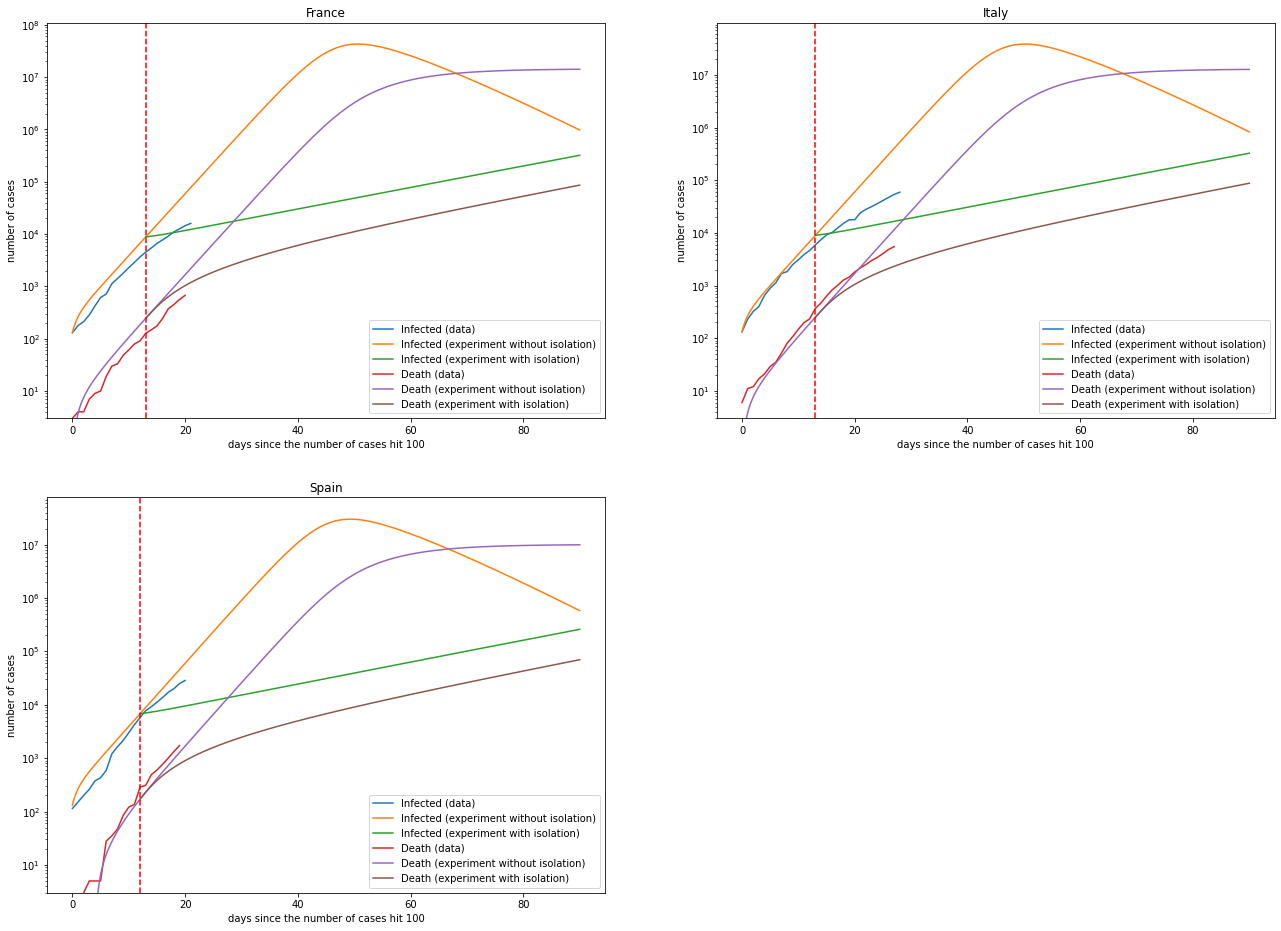

In [123]:
figure(figsize=(22,16))

subplot(221)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('France')

semilogy(days100_France, cases100_France, label=r'Infected (data)')
semilogy(t, Lt_f[:,1]+Lt_f[:,2], label=r'Infected (experiment without isolation)')
semilogy(tq, Lt_fq[:,1]+Lt_fq[:,2], label=r'Infected (experiment with isolation)')

semilogy(days100_France, death_France_sync, label=r'Death (data)')
semilogy(t, Ndeath_f, label=r'Death (experiment without isolation)')
semilogy(tq, Ndeath_fq, label=r'Death (experiment with isolation)')

axvline(13, color='red', linestyle='dashed')
ylim(bottom=3)
legend()

subplot(222)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('Italy')

semilogy(days100_Italy, cases100_Italy, label=r'Infected (data)')
semilogy(t, Lt_i[:,1]+Lt_i[:,2], label=r'Infected (experiment without isolation)')
semilogy(tq, Lt_iq[:,1]+Lt_iq[:,2], label=r'Infected (experiment with isolation)')

semilogy(days100_Italy, death_Italy_sync, label=r'Death (data)')
semilogy(t, Ndeath_i, label=r'Death (experiment without isolation)')
semilogy(tq, Ndeath_iq, label=r'Death (experiment with isolation)')

axvline(13, color='red', linestyle='dashed')
ylim(bottom=3)
legend()

subplot(223)
xlabel(r'days since the number of cases hit 100')
ylabel(r'number of cases')
title('Spain')

semilogy(days100_Spain, cases100_Spain, label=r'Infected (data)')
semilogy(t, Lt_s[:,1]+Lt_s[:,2], label=r'Infected (experiment without isolation)')
semilogy(tqs, Lt_sq[:,1]+Lt_sq[:,2], label=r'Infected (experiment with isolation)')

semilogy(days100_Spain, death_Spain_sync, label=r'Death (data)')
semilogy(t, Ndeath_s, label=r'Death (experiment without isolation)')
semilogy(tqs, Ndeath_sq, label=r'Death (experiment with isolation)')

axvline(12, color='red', linestyle='dashed')
ylim(bottom=3)
legend()
show()


The new data are much better! But clearly, there is an inertia in real life that our brutal change of parameter in the model could not reproduce... Nevertheless, we see the clear impact of the quarantine: people get infected at a lower rate, hence not gathering all at the same time in hospitals!